# ABS in cQED essentials

### Part 1: Andreev bound states in various limits

### Part 2: ABS in a resonator

### References:
 - Nazarov & Blanter, Quantum Transport textbook
 - [Landry Bretheau PhD thesis, 2013](http://pastel.archives-ouvertes.fr/pastel-00862029)
 - [Camille Janvier PhD thesis, 2016](http://iramis.cea.fr/spec/Pres/Quantro/static/wp-content/uploads/2010/10/these_JANVIE.pdf)
 - [Bretheau et al, PRB 2014](http://arxiv.org/pdf/1406.6301.pdf)
 - [van Woerkom et al, Nat. Phys. 2016 and supplement](https://arxiv.org/pdf/1609.00333)
 

####  ABS-resonator code is adapted from the work of Bernard van Heck
see [open data folder of van Woerkom et al](http://dx.doi.org/10.4121/uuid:8c4a0604-ac00-4164-a37a-dad8b9d2f580)

In [1]:
#required stuff
%matplotlib nbagg
import matplotlib.pyplot as plt
from scipy import signal, ndimage, special
from scipy import optimize
#from scipy import linalg
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import scipy.linalg as la
import numpy as np
from ipywidgets import *
import ipywidgets as ipw


In [2]:
#ignore stupid pink box warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
fparams = {'axes.labelsize': 18,
           'axes.titlesize': 18,
           'font.size': 18,
           'legend.fontsize': 16,
           'font.family': 'serif',
           'xtick.labelsize': 16,
           'ytick.labelsize': 16,
           'figure.autolayout': True}
plt.rcParams.update(fparams)

## Basic model

Model system: weak link with a phase difference of $\varphi$.

![caption](figures/SNS_junction.png)

We are looking for the solution of a particle-in-the-box problem, with a nontrivial phase $\pm{\varphi_{L,R}}-\arccos(E/\Delta)$ picked up at the interfaces. This yields the condition

$$
\varphi-2\arccos(E/\Delta) = n 2\pi
$$

$$
E=\pm\Delta \cos{\phi/2}
$$

In [4]:
def ABS_E(phi):
    return np.cos(phi/2)

<IPython.core.display.Javascript object>


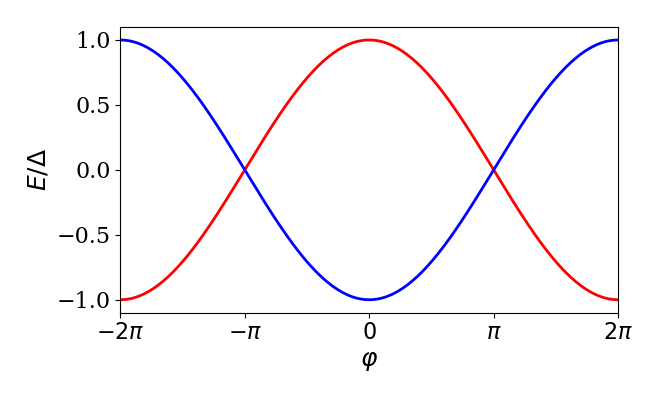

In [5]:
phasevals = np.linspace(-2*np.pi,2*np.pi,num=200);

fig, ax = plt.subplots(figsize=(6.6,4))

ax.plot(phasevals, [ABS_E(p) for p in phasevals], "r-", linewidth=2)
ax.plot(phasevals, [-ABS_E(p) for p in phasevals], "b-", linewidth=2)
ax.set_xlim(-2*np.pi, 2*np.pi)
ax.set_xticks([-2*np.pi, -np.pi, 0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$-2\pi$', r'$-\pi$', r'$0$', r'$\pi$', r'$2\pi$'])
ax.set_xlabel(r'$\varphi$')
ax.set_ylabel(r'$E/\Delta$')
fig.show()

The crossing point are at $\varphi=(2n+1)\pi$. Here, the phase dispersion is $dE/d\varphi=\Delta/2$. We will come back to this.

## Now with finite channel transmission

We put a scatterer in the channel with the $S$ matrix:
$$
S=\begin{vmatrix} r & t \\ t & -r\end{vmatrix}
$$
with $t=\sqrt{T}$ and $r=\sqrt{1-T}$ expressed with the channel transmission $T$.
With electron-hole spinors, this looks like:
$$
S_{ch}=\begin{vmatrix} S & 0 \\ 0 & S^\dagger\end{vmatrix}
$$
We use the following basis (left-right, electron-hole): $v=[Le,Re,Lh,Rh]$. The $S$ matrix of the leads in the same basis is then:
$$
S_{l}=\begin{vmatrix} 0 & 0 &\exp{i\xi'_L} & 0 \\ 0 & 0 & 0 & \exp{i\xi'_R} \\ \exp{i\xi_L} & 0 & 0 & 0 \\ 0& \exp{i\xi_R} & 0 & 0\end{vmatrix}
$$
where $\xi^{(')}=-\arccos{E/\Delta}+\pm(\varphi)$.

The steady-state solutions are given by: $S_{ch}S_L v =v$, consequently $\det(S_{ch}S_L-1)=0$. The well-known analytic solution is:
$$
E_{ABS}=\pm\Delta\sqrt{1-T\sin^2(\varphi/2)}.
$$

In [6]:
def ABS_short(phi, t=0.9):
    return np.sqrt(1-t*(np.sin(phi/2))**2)

<IPython.core.display.Javascript object>


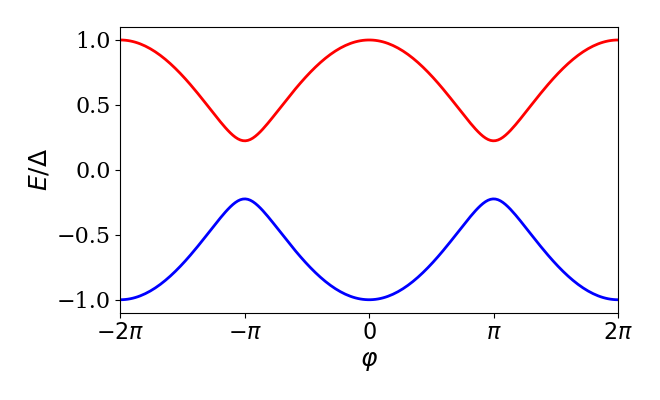

interactive(children=(FloatSlider(value=0.9, description='T', max=1.0, step=0.05), Output()), _dom_classes=('w…

In [25]:
phasevals = np.linspace(-2*np.pi,2*np.pi,num=200);
fig, ax = plt.subplots(figsize=(6.6,4))
line1, = ax.plot(phasevals, [ABS_short(p,0.9) for p in phasevals], "r-", linewidth=2)
line2, = ax.plot(phasevals, [-ABS_short(p,0.9) for p in phasevals], "b-", linewidth=2)
ax.set_xlim(-2*np.pi, 2*np.pi)
ax.set_xticks([-2*np.pi, -np.pi, 0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$-2\pi$', r'$-\pi$', r'$0$', r'$\pi$', r'$2\pi$'])
ax.set_xlabel(r'$\varphi$')
ax.set_ylabel(r'$E/\Delta$')
fig.show()

def update(T=0.9):
    line1.set_ydata([ABS_short(p,T) for p in phasevals])
    line2.set_ydata([-ABS_short(p,T) for p in phasevals])
    fig.canvas.draw_idle()
interact(update, T=(0,1.0,0.05));

### But we can also do this numerically

In [8]:
#channel S matrix
#input parameter: t, channel transmission
def Sch(T):
    t = np.sqrt(T)
    r=np.sqrt(1-T)
    return np.array([[r,t,0,0],[t,-r,0,0],[0,0,r,t],[0,0,t,-r]])

#helper functions for angle calculation
def xi(E,p):
    return -np.arccos(E)-p

def xit(E,p):
    return -np.arccos(E)+p

#leads S matrix
#input parameters:
# phi: phase of right lead
# E: energy normalized by the gap
def Sl(E,phi):
    return np.array([[0,0,np.complex(np.cos(xit(E,0)),np.sin(xit(E,0))),0], \
                    [0,0,0,np.complex(np.cos(xit(E,phi)),np.sin(xit(E,phi)))], \
                    [np.complex(np.cos(xi(E,0)),np.sin(xi(E,0))),0,0,0], \
                    [0,np.complex(np.cos(xi(E,phi)),np.sin(xi(E,phi))),0,0]])

def Sdet_all(E,t,phi):
    temp = la.det(np.dot(Sch(t), Sl(E,phi))-np.identity(4))
    return [np.real(temp),np.imag(temp)]

def ABS_short_Smatrix(t,phi,Einit):
    return optimize.root(Sdet_all,Einit,args=(t,phi), method='lm', jac=None, tol=1e-5, callback=None, options=None)['x'][0]

<IPython.core.display.Javascript object>


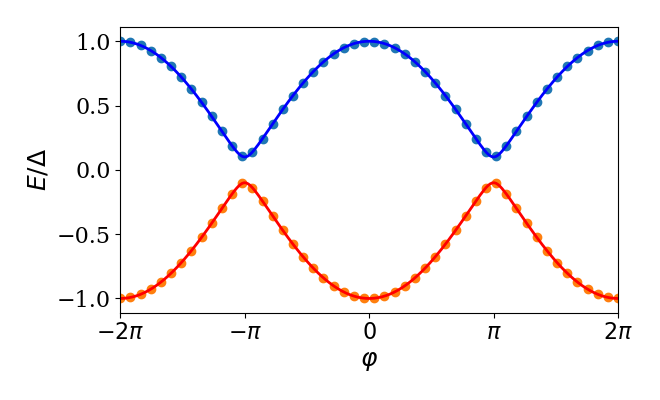

In [9]:
t=0.99
phasevals = np.linspace(-2*np.pi,2*np.pi,num=50);
phasevals_fine = np.linspace(-2*np.pi,2*np.pi,num=250);
fig, ax = plt.subplots(figsize=(6.6,4))
ax.set_xlim(-2*np.pi, 2*np.pi)
ax.set_xticks([-2*np.pi, -np.pi, 0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$-2\pi$', r'$-\pi$', r'$0$', r'$\pi$', r'$2\pi$'])
ax.set_xlabel(r'$\varphi$')
ax.set_ylabel(r'$E/\Delta$')

energies_pos = [ABS_short_Smatrix(t,p,0.5) for p in phasevals]
energies_neg = [ABS_short_Smatrix(t,p,-0.5) for p in phasevals]
ax.scatter(phasevals,energies_pos)
ax.scatter(phasevals,energies_neg)
ax.plot(phasevals_fine, ABS_short(phasevals_fine, t), "b-", linewidth=2)
ax.plot(phasevals_fine, [-v for v in ABS_short(phasevals_fine, t)], "r-", linewidth=2)

fig.show()

## Long(er) junction limit
We add an additional phase due to finite propagation time through the channel:

$$
\varphi-2\arccos(E/\Delta)-2E/E_{Th} = n 2\pi
$$

where $E_{Th}$ is the Thouless energy. Note that this comes from $Lk=LE/\hbar v_F=E/E_{th}$ (ballistic channels only). Here we can have solutions for multiple $n$ values.

In [10]:
#function to feed the numerical solver with
def ABS_long_eq(E,phi,Delta,Eth,n,sign):
    return -sign*phi+2*np.arccos(E/Delta)-2*E/Eth-2*sign*np.pi*n

def ABS_long(phi,Delta,Eth,n,sign):
    return optimize.fsolve(ABS_long_eq,0,args=(phi,Delta,Eth,n,sign),full_output=True,factor=1.0, xtol=1e-6)
    
def ABS_sanitize(phi,Delta,Eth,n,sign):
    temp = ABS_long(phi,Delta,Eth,n,sign)
    if temp[2] == 1:
        return temp[0][0]
    else:
        return np.nan

<IPython.core.display.Javascript object>


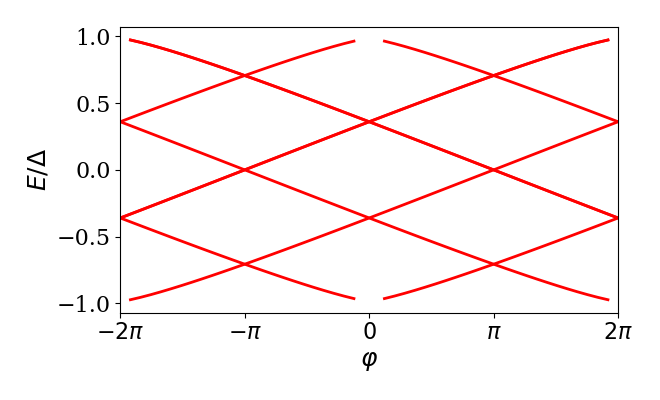

In [28]:
phasevals = np.linspace(-2*np.pi,2*np.pi,num=50);
Delta = 1
Eth=0.3
nmax=5
fig, ax = plt.subplots(figsize=(6.6,4))
ax.set_xlim(-2*np.pi, 2*np.pi)
ax.set_xticks([-2*np.pi, -np.pi, 0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$-2\pi$', r'$-\pi$', r'$0$', r'$\pi$', r'$2\pi$'])
ax.set_xlabel(r'$\varphi$')
ax.set_ylabel(r'$E/\Delta$')

for n in range(nmax):
    ax.plot(phasevals, [ABS_sanitize(p,Delta,Eth,n,1) for p in phasevals], "r-", linewidth=2)
    ax.plot(phasevals, [ABS_sanitize(p,Delta,Eth,n,-1) for p in phasevals], "r-", linewidth=2)
    ax.plot(phasevals, [ABS_sanitize(p,Delta,Eth,-n,1) for p in phasevals], "r-", linewidth=2)
    ax.plot(phasevals, [ABS_sanitize(p,Delta,Eth,-n,-1) for p in phasevals], "r-", linewidth=2)

fig.show()

Once again see the zero crossing points $\varphi=(2n+1)\pi$. Here we can rewrite the steady-state condition:
$$
\pi-\delta-2\arccos(E/\Delta)-2E/E_{Th}=0
$$

which yields at small $\delta$:
$$
E\left(\frac{1}{\Delta}+\frac{1}{E_{Th}}\right)=\delta/2
$$
corresponding to an effective gap of
$$
\frac{1}{\Delta'}=\frac{1}{\Delta}+\frac{1}{E_{Th}}.
$$
Reasonably, this carries over to finite $T$ cases, but we can check this.

## Long junction with S-matrix formalism

We fix the extra phase in the lead matrix:
$$
S_{l}=\begin{vmatrix} 0 & 0 &\exp{i(\xi'_L+\alpha)} & 0 \\ 0 & 0 & 0 & \exp{i(\xi'_R+\alpha)} \\ \exp{i(\xi_L+\alpha)} & 0 & 0 & 0 \\ 0& \exp{i(\xi_R+\alpha)} & 0 & 0\end{vmatrix},
$$

where $\alpha=E/E_{Th}$.

In [12]:
#channel S matrix
#input parameter: t, channel transmission
def Sch(T):
    t = np.sqrt(T)
    r=np.sqrt(1-T)
    return np.array([[r,t,0,0],[t,-r,0,0],[0,0,r,t],[0,0,t,-r]])

#helper functions for angle calculation
def xi_L(E,Eth,p):
    return -np.arccos(E)+E/Eth-p

def xit_L(E,Eth,p):
    return -np.arccos(E)+E/Eth+p

#leads S matrix
#input parameters:
# phi: phase of right lead
# E: energy normalized to the gap
# Eth: Thouless energy, normalized to the gap
def Sl_L(E,Eth,phi):
    return np.array([[0,0,np.complex(np.cos(xit_L(E,Eth,0)),np.sin(xit_L(E,Eth,0))),0], \
                    [0,0,0,np.complex(np.cos(xit_L(E,Eth,phi)),np.sin(xit_L(E,Eth,phi)))], \
                    [np.complex(np.cos(xi_L(E,Eth,0)),np.sin(xi_L(E,Eth,0))),0,0,0], \
                    [0,np.complex(np.cos(xi_L(E,Eth,phi)),np.sin(xi_L(E,Eth,phi))),0,0]])

def Sdet_L_all(E,Eth,t,phi):
    temp = la.det(np.dot(Sch(t), Sl_L(E,Eth,phi))-np.identity(4))
    return np.abs(temp)

def ABS_L_Smatrix(Eth,t,phi,Einit,window):
    return optimize.minimize(Sdet_L_all,Einit,args=(Eth,t,phi), method='SLSQP', jac=None, hess=None, hessp=None, bounds=[(Einit-window,Einit+window)], constraints=(), tol=None, callback=None, options=None)

def ABS_L_sanitize(Eth,t,phi,Einit,window):
    tol= 1e-5
    temp = ABS_L_Smatrix(Eth, t, phi, Einit, window)
    if np.abs(temp['fun']) < tol:
        return temp['x'][0]
    else:
        return np.nan

### Now some plots...

In [35]:
t=0.9
Eth=0.3
Delta=1
window = 0.2
nmax=4

<IPython.core.display.Javascript object>


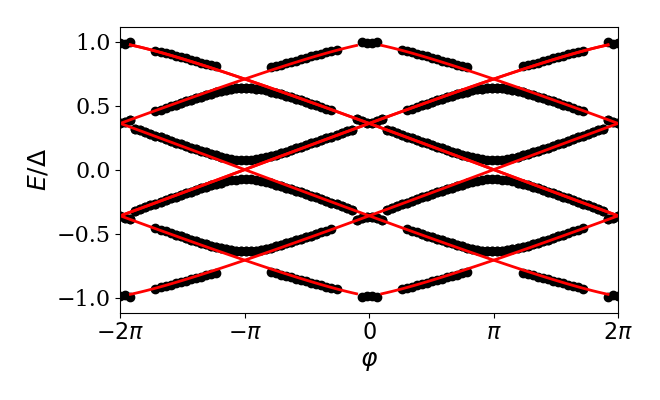

In [36]:
#lot of plotting below...

phasevals = np.linspace(-2*np.pi,2*np.pi,num=100);
phasevals_fine = np.linspace(-2*np.pi,2*np.pi,num=500);

fig, ax = plt.subplots(figsize=(6.6,4))
ax.set_xlim(-2*np.pi, 2*np.pi)
ax.set_xticks([-2*np.pi, -np.pi, 0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$-2\pi$', r'$-\pi$', r'$0$', r'$\pi$', r'$2\pi$'])
ax.set_xlabel(r'$\varphi$')
ax.set_ylabel(r'$E/\Delta$')


ax.scatter(phasevals,[ABS_L_sanitize(Eth, t, p, 0.1,window) for p in phasevals], c="black")
ax.scatter(phasevals,[ABS_L_sanitize(Eth, t, p, -0.1,window) for p in phasevals], c="black")

ax.scatter(phasevals,[ABS_L_sanitize(Eth, t, p, 0.3,window) for p in phasevals], c="black")
ax.scatter(phasevals,[ABS_L_sanitize(Eth, t, p, -0.3,window) for p in phasevals], c="black")

ax.scatter(phasevals,[ABS_L_sanitize(Eth, t, p, 0.5,window) for p in phasevals], c="black")
ax.scatter(phasevals,[ABS_L_sanitize(Eth, t, p, -0.5,window) for p in phasevals], c="black")

ax.scatter(phasevals,[ABS_L_sanitize(Eth, t, p, 0.7,window) for p in phasevals], c="black")
ax.scatter(phasevals,[ABS_L_sanitize(Eth, t, p, -0.7,window) for p in phasevals], c="black")

ax.scatter(phasevals,[ABS_L_sanitize(Eth, t, p, 0.9,0.099) for p in phasevals], c="black")
ax.scatter(phasevals,[ABS_L_sanitize(Eth, t, p, -0.9,0.099) for p in phasevals], c="black")

for n in range(nmax):
    ax.plot(phasevals, [ABS_sanitize(p,Delta,Eth,n,1) for p in phasevals], "r-", linewidth=2)
    ax.plot(phasevals, [ABS_sanitize(p,Delta,Eth,n,-1) for p in phasevals], "r-", linewidth=2)
    ax.plot(phasevals, [ABS_sanitize(p,Delta,Eth,-n,1) for p in phasevals], "r-", linewidth=2)
    ax.plot(phasevals, [ABS_sanitize(p,Delta,Eth,-n,-1) for p in phasevals], "r-", linewidth=2)

plt.show()

### Compare with renormalized gap equation

In [15]:
Eth=0.5
t=0.95

<IPython.core.display.Javascript object>


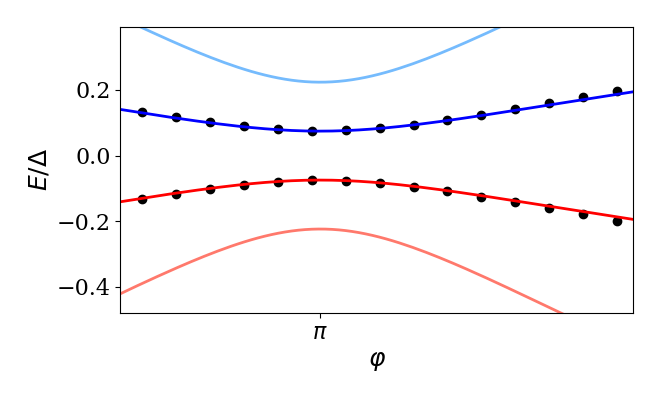

In [16]:
#lot of plotting below...
phasevals = np.linspace(-2*np.pi,2*np.pi,num=100);
phasevals_fine = np.linspace(-2*np.pi,2*np.pi,num=500);

fig, ax = plt.subplots(figsize=(6.6,4))
ax.set_xlim(-2*np.pi, 2*np.pi)
ax.set_xticks([-2*np.pi, -np.pi, 0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$-2\pi$', r'$-\pi$', r'$0$', r'$\pi$', r'$2\pi$'])
ax.set_xlabel(r'$\varphi$')
ax.set_ylabel(r'$E/\Delta$')

energies_pos = [ABS_L_sanitize(Eth, t, p, 0.3,0.5) for p in phasevals]
energies_neg = [ABS_L_sanitize(Eth, t, p, -0.3,0.5) for p in phasevals]

ax.scatter(phasevals,energies_pos, c="black")
ax.scatter(phasevals,energies_neg, c="black")

scale = 1/(1+1/Eth)

ax.plot(phasevals_fine, [scale*v for v in ABS_short(phasevals_fine, t)], "b-", linewidth=2)
ax.plot(phasevals_fine, [-scale*v for v in ABS_short(phasevals_fine, t)], "r-", linewidth=2)

ax.plot(phasevals_fine, [v for v in ABS_short(phasevals_fine, t)], color="xkcd:sky blue", linewidth=2)
ax.plot(phasevals_fine, [-v for v in ABS_short(phasevals_fine, t)], color="xkcd:salmon", linewidth=2)

fig.show()

## Quantum description of the ABS

Previously we used the phase $\varphi$ as a classical variable. From now on, we use the phase and charge number operators: $[\varphi, N]=i$ and consider the following circuit model.
![caption](figures/squid.png)

Note that this is a DC SQUID geometry with an SIS junction of $E_J$, but in the limit of small phase fluctuations, $\phi \ll 2\pi$, it acts as a linear inductor with $E_J \rightarrow E_L$.

### Some common notations

Resonator frequency: $\hbar \omega_r=\sqrt{2E_C E_L}=\frac{\hbar}{\sqrt{LC}}$.

Dimensionless resonator impedance: $z=\pi\frac{Z_R}{R_Q}=\sqrt{\frac{E_C}{2E_L}}$, where 
    $Z_R=\sqrt{\frac{L}{C}}$.

In case of a mutual inductive or partial inductive coupling $L_c$: $z=\pi\frac{L_c^2 Z_R}{L^2 R_Q}$, which is an effective impedance transformation with a ratio of $(L_c/L)^2$.

# The Hamiltonian

$$H = E_C\sigma_0\hat{N}^2 -E_J\,\sigma_0\cos(\hat\phi)+ H_A(\varphi-\hat{\phi})$$
or
$$H = E_C\sigma_0\hat{N}^2 +E_L\,\sigma_0\hat\phi^2+ H_A(\varphi-\hat{\phi})=\hbar\omega_ra^\dagger a + H_A(\varphi-\hat{\phi}) $$

$$
H_A(\hat\phi)= E_A\sigma_3\,V_3(\hat\phi) + E_A\,\sigma_2\,V_2(\hat\phi)\\
V_3(\hat\phi)=\cos\frac{\sqrt{R}\hat\phi}{2}\,\cos\frac{\hat\phi}{2}+\sqrt{R}\,\sin\frac{\sqrt{R}\hat\phi}{2}\,\sin\frac{\hat\phi}{2}\\
V_2(\hat\phi)=\sqrt{R}\,\cos\frac{\sqrt{R}\hat\phi}{2}\,\sin\frac{\hat\phi}{2}-\sin\frac{\sqrt{R}\hat\phi}{2}\,\cos\frac{\hat\phi}{2}
$$

where $E_A$ is the (effective) superconducting gap and $R=1-T$ is the reflection probability. $\sigma_i$ are the Pauli matrices.

In [17]:
class SimpleNamespace(object):
    """A simple container for parameters."""
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)


The Hamiltonian is represented in the phase basis, with a spacing of $2\pi/M$, where $M$ is set such that the solutions found are converged with a preset tolerance. This mostly depends on the impedance of the harmonic oscillator.

In [18]:
def potential(phi, p, s='0'):
    r = np.sqrt(1 - p.T) # use reflection amplitude in the formulas, for brevity
    if s == 'z':
        phi = p.flux - phi
        return np.cos(0.5 * r * phi) * np.cos(0.5 * phi) + r * np.sin(0.5 * r * phi) * np.sin(0.5 * phi)
    elif s  == 'y':
        phi = p.flux - phi
        return r * np.cos(0.5 * r * phi) * np.sin(0.5 * phi) - np.sin(0.5 * r * phi) * np.cos(0.5 * phi)
    elif s == '0':
        return (1 - np.cos(phi))
    else:
        raise ValueError('wrong value of s')
        
def n_me(M, dk):
    x = np.pi * dk / M
    return (-1)**dk  / (np.tan(x) * np.sin(x)) / 2

def create_hamiltonian(p, M, sparse=False):
    # offset diagonal term from charging energy
    h0 = p.Ec * (M**2 - 1) / 12 * np.eye(M) + 0j
    
    # cosine part of the potential
    ks = np.arange(-(M-1)/2, (M+1)/2, 1)
    h0 += p.Ej * np.diag(np.array([potential(2 * np.pi * k / M, p, '0') for k in ks])) + 0j
     
    #off diagonal parts of the charging energy
    for dk in range(1, M):
        h0 += p.Ec * n_me(M, dk) * (np.eye(M, k=dk) + np.eye(M, k=-dk)) + 0j
    
    # z, y parts of the potential
    hz = p.Ea * np.diag(np.array([potential(2 * np.pi * k / M, p, 'z') for k in ks])) + 0j
    hy = p.Ea * np.diag(np.array([potential(2 * np.pi * k / M, p, 'y') for k in ks])) + 0j
    
    h = np.bmat([[h0 + hz, -1j * hy], [1j * hy, h0 - hz]])
    if sparse:
        return sp.coo_matrix(h)
    else:
        return np.array(h)
    
def find_optimal_M(p, max_tol = 9e-8, verbose=False):
    M = 3
    tol = 100
    H = create_hamiltonian(p, M, sparse=False)
    ens = np.linalg.eigvalsh(H)
    de = ens[1]-ens[0]
    while tol > max_tol:
        M += 4
        H = create_hamiltonian(p, M, sparse=False)
        ens = np.linalg.eigvalsh(H)
        de_new = ens[1]-ens[0]
        tol = np.abs(de_new - de)
        if verbose:
            print(M, de, de_new, tol)
        de = de_new
    return M

def spectrum(p, M, sparse=False):
    spectra = []
    H = create_hamiltonian(p, M, sparse=False)
    ens = np.sort(la.eigvalsh(H, eigvals=(0,10)))
    spectra = ens - ens[0]
    return [ens, spectra]


### Low impedance resonator

In [19]:
p = SimpleNamespace(Ej = 900, Ea = 43, Ec=0.270, T=0.985, flux=np.pi)
M = find_optimal_M(p, max_tol = 1e-6, verbose=False)
print(M)

63


<IPython.core.display.Javascript object>


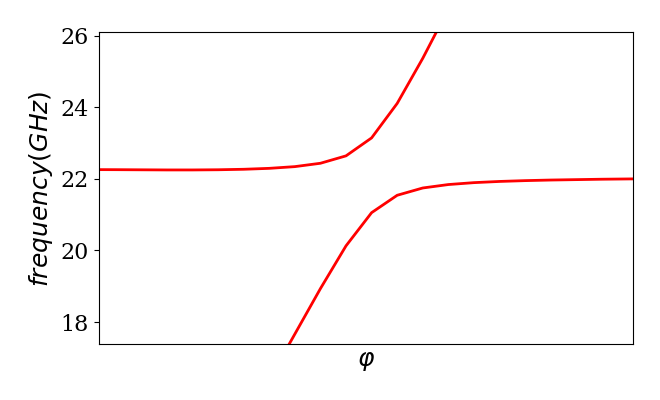

In [20]:
#lot of plotting here
#M= find_optimal_M(p, max_tol = 1e-6, verbose=False)
#print(M)
numph=320
phasevals = np.linspace(-2*np.pi,2*np.pi,num=numph);
imax = 10
fig, ax = plt.subplots(figsize=(6.6,4))
ax.set_xlim(-2*np.pi, 2*np.pi)
ax.set_ylim(0, 2*p.Ea)
ax.set_xticks([-2*np.pi, -np.pi, 0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$-2\pi$', r'$-\pi$', r'$0$', r'$\pi$', r'$2\pi$'])
ax.set_xlabel(r'$\varphi$')
ax.set_ylabel(r'$frequency (GHz)$')

frequencies = np.zeros(shape=(imax,numph))

for pn in range(numph):
    p.flux = phasevals[pn]
    temp = spectrum(p,M)
    for i in range(imax):
        frequencies[i][pn]=temp[1][i+1]

for i in range(imax):
    ax.plot(phasevals, frequencies[i], "r-", linewidth=2)
    
fig.show()


### Higher impedance resonator

In [21]:
p = SimpleNamespace(Ej = 100, Ea = 43, Ec=2.43, T=0.985, flux=np.pi)
M = find_optimal_M(p, max_tol = 1e-6, verbose=False)
print(M)

23


<IPython.core.display.Javascript object>


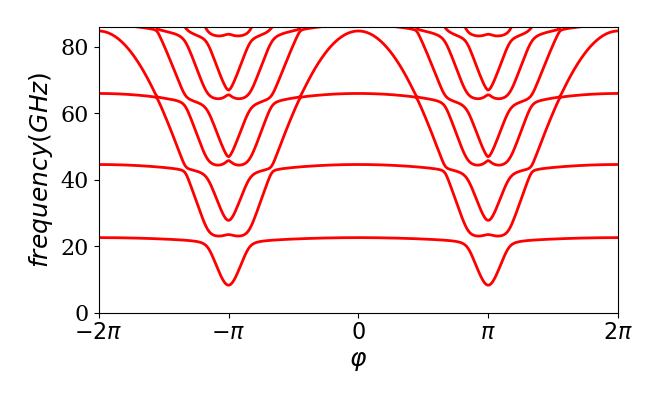

In [22]:
#lot of plotting here
#M= find_optimal_M(p, max_tol = 1e-6, verbose=False)
#print(M)
numph=320
phasevals = np.linspace(-2*np.pi,2*np.pi,num=numph);
imax = 10
fig, ax = plt.subplots(figsize=(6.6,4))
ax.set_xlim(-2*np.pi, 2*np.pi)
ax.set_ylim(0, 2*p.Ea)
ax.set_xticks([-2*np.pi, -np.pi, 0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$-2\pi$', r'$-\pi$', r'$0$', r'$\pi$', r'$2\pi$'])
ax.set_xlabel(r'$\varphi$')
ax.set_ylabel(r'$frequency (GHz)$')

frequencies = np.zeros(shape=(imax,numph))

for pn in range(numph):
    p.flux = phasevals[pn]
    temp = spectrum(p,M)
    for i in range(imax):
        frequencies[i][pn]=temp[1][i+1]

for i in range(imax):
    ax.plot(phasevals, frequencies[i], "r-", linewidth=2)
    
fig.show()

### Even higher impedance resonator

In [23]:
p = SimpleNamespace(Ej = 33, Ea = 43, Ec=7.29, T=0.985, flux=np.pi)
M = find_optimal_M(p, max_tol = 1e-6, verbose=False)
print(M)

191


<IPython.core.display.Javascript object>


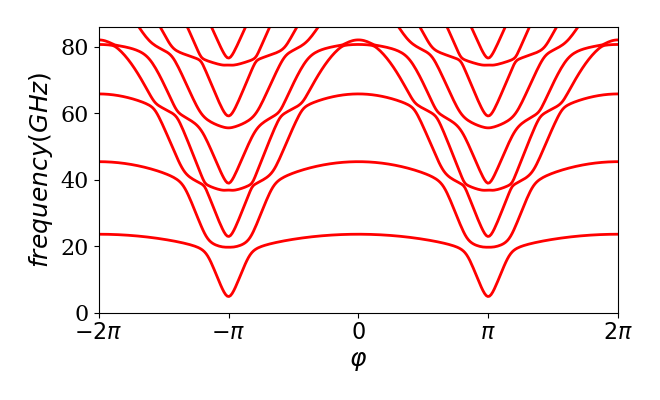

In [24]:
#lot of plotting here
#M= find_optimal_M(p, max_tol = 1e-6, verbose=False)
#print(M)
numph=320
phasevals = np.linspace(-2*np.pi,2*np.pi,num=numph);
imax = 10
fig, ax = plt.subplots(figsize=(6.6,4))
ax.set_xlim(-2*np.pi, 2*np.pi)
ax.set_ylim(0, 2*p.Ea)
ax.set_xticks([-2*np.pi, -np.pi, 0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$-2\pi$', r'$-\pi$', r'$0$', r'$\pi$', r'$2\pi$'])
ax.set_xlabel(r'$\varphi$')
ax.set_ylabel(r'$frequency (GHz)$')

frequencies = np.zeros(shape=(imax,numph))

for pn in range(numph):
    p.flux = phasevals[pn]
    temp = spectrum(p,M)
    for i in range(imax):
        frequencies[i][pn]=temp[1][i+1]

for i in range(imax):
    ax.plot(phasevals, frequencies[i], "r-", linewidth=2)
    
fig.show()

Let's take a look at that Hamiltonian again:
$$H = \hbar\omega_r a^\dagger a + H_A(\varphi-\hat{\phi}) \approx \hbar\omega_ra^\dagger a +  H_A(\varphi-\phi) + \frac{\partial H_A}{\partial \phi} \hat{\delta} + \ldots$$

which yields the first order coupling Hamiltonian:
$$
H_c=L_{(c)}\hat{I}_R\hat{I}_A.
$$

This Hamiltonian further yields:
$$
H_c=g(a^\dagger + a)\sigma_1
$$
with
$$
g=\frac{E_A T \sqrt{z}}{2} \text{ at } \varphi=\pi. 
$$
Note that this formulation is compatible with the usual Jaynes-Cummings RWA framework, yielding e.g. a dispersive shift of
$$
\chi = \frac{g^2}{\Delta_{detune}}
$$

# Thank you for your attention!